# **Chargement librairies**


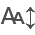

In [13]:
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import joblib
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# **Chargement des datasets**

In [14]:
# Charger les données
df_clean = pd.read_csv("../data/df_clean.csv", sep=';', index_col='Monture_ID')
df = df_clean.copy()

# Nettoyage des valeurs de la colonne 'Taille'
df['Taille'] = df['Taille'].astype(str).str.replace(r'\s+', '', regex=True)  # enlever tous les espaces

# Séparer taille en 3 colonnes
taille_split = df['Taille'].str.split('-', expand=True)

for i in range(3):
    if i not in taille_split.columns:
        taille_split[i] = 0

df['Taille_Lens'] = pd.to_numeric(taille_split[0], errors='coerce')
df['Taille_Bridge'] = pd.to_numeric(taille_split[1], errors='coerce')
df['Taille_Temple'] = pd.to_numeric(taille_split[2], errors='coerce')
df.drop(columns=['Taille'], inplace=True)

df.head()


Genre   Marque          Type     Forme   Materiau  \
Monture_ID                                                            
MON14150          Homme   Oakley       Cerclee     Ronde  Plastique   
MON98676    Non-binaire  Ray-Ban  Semi-cerclee  Aviateur      Metal   
MON20808    Non-binaire   Oakley       Cerclee     Ronde     Titane   
MON92263          Homme  Ray-Ban       Cerclee  Aviateur  Plastique   
MON29264          Femme  Ray-Ban       Cerclee  Aviateur  Plastique   

                Couleur     Style  Age  Taille_Lens  Taille_Bridge  \
Monture_ID                                                           
MON14150    Transparent     Sport   39           55             17   
MON98676    Transparent  Business   27           58             15   
MON20808        Ecaille     Sport   74           51             15   
MON92263           Noir      Luxe   36           58             18   
MON29264           Noir    Casual   20           59             14   

            Taille_Temple  
Monture_ID                 
MON14150              134  
MON98676              139  
MON20808              136  
MON92263              141  
MON29264              147

# **Encodage des variables**

In [15]:
# Colonnes à encoder
cat_cols = ['Genre', 'Marque', 'Type', 'Forme', 'Materiau', 'Couleur', 'Style']
num_cols = ['Age', 'Taille_Lens', 'Taille_Bridge', 'Taille_Temple']

# Encoder les variables catégorielles
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
ohe.fit(df[cat_cols])
X_cat = ohe.transform(df[cat_cols])

# Standardiser les variables numériques
scaler = StandardScaler()
scaler.fit(df[num_cols])
X_num = scaler.transform(df[num_cols])

# Sauvegarder les encodeurs
joblib.dump(ohe, "../models/ohe_encoder_cb.pkl")
joblib.dump(scaler, "../models/scaler_cb.pkl")

['../models/scaler_cb.pkl']

# **Entrainement des modèles**

# **Content-based filtering**

## **k-NN**

In [16]:
# Fusion des features
X_encoded = np.hstack([X_cat, X_num])

# Création du modèle k-NN
knn = NearestNeighbors(n_neighbors=10, metric='euclidean')
knn.fit(X_encoded)

joblib.dump(knn, "../models/knn_model.pkl")

# Prêt à tester un profil utilisateur encodé
X_encoded.shape

(99654, 32)

In [17]:
# ==== Teste du K-NN avec un profil utilisateur ====

# === Charger les encodeurs et le modèle k-NN
ohe = joblib.load("../models/ohe_encoder_cb.pkl")
scaler = joblib.load("../models/scaler_cb.pkl")
knn = joblib.load("../models/knn_model.pkl")

# === Définir un profil utilisateur simulé
profil = {
    'Genre': ['Homme'],
    'Marque': ['Ray-Ban'],
    'Type': ['Cerclée'],
    'Forme': ['Rectangulaire'],
    'Materiau': ['Acier'],
    'Couleur': ['Noir'],
    'Style': ['Business'],
    'Age': [32],
    'Taille_Lens': [54],
    'Taille_Bridge': [18],
    'Taille_Temple': [140]
}

# === Encodage du profil utilisateur
profil_cat = ohe.transform(pd.DataFrame(profil)[ohe.feature_names_in_])
profil_num = scaler.transform(pd.DataFrame(profil)[['Age', 'Taille_Lens', 'Taille_Bridge', 'Taille_Temple']])
profil_encoded = np.hstack([profil_cat, profil_num])

# === Calcul des voisins les plus proches
distances, indices = knn.kneighbors(profil_encoded)

# === Récupération des Monture_IDs les plus proches
montures_proches = df.index[indices[0]].tolist()

print("🔎 Montures recommandées (IDs):", montures_proches)


🔎 Montures recommandées (IDs): ['MON58743', 'MON1116', 'MON72696', 'MON55925', 'MON56132', 'MON73356', 'MON3886', 'MON56132', 'MON58742', 'MON15883']


In [18]:
import matplotlib.pyplot as plt

def afficher_recommandations(df, montures_ids, lignes=5, colonnes=2):
    """
    Affiche une grille des montures recommandées avec leurs détails.
    Compatible avec les emojis sous Windows (Segoe UI Emoji).
    
    - df : DataFrame avec les infos montures (index = Monture_ID)
    - montures_ids : liste des IDs recommandés
    - lignes / colonnes : dimensions de l'affichage
    """
    # Changer la police pour afficher les emojis (Windows)
    plt.rcParams['font.family'] = 'Segoe UI Emoji'

    # Supprimer les doublons éventuels
    if not df.index.is_unique:
        df = df[~df.index.duplicated(keep='first')]

    fig, axes = plt.subplots(lignes, colonnes, figsize=(8, 2 * lignes))
    axes = axes.flatten()

    for i, idx in enumerate(montures_ids):
        ax = axes[i]

        if idx not in df.index:
            ax.axis('off')
            continue

        monture = df.loc[[idx]].iloc[0]

        details = "\n".join([
            f"🆔 {idx}",
            f"👓 Marque : {monture['Marque']}",
            f"🎨 Couleur : {monture['Couleur']}",
            f"🔷 Forme : {monture['Forme']}",
            f"🧵 Matériau : {monture['Materiau']}",
            f"🧍 Genre : {monture['Genre']}",
            f"👔 Style : {monture['Style']}",
            f"📏 Taille : {int(monture['Taille_Lens'])}-{int(monture['Taille_Bridge'])}-{int(monture['Taille_Temple'])}",
            f"🎂 Âge cible : {int(monture['Age'])}"
        ])

        ax.text(0.5, 0.5, details, ha='center', va='center', fontsize=10, wrap=True)
        ax.axis('off')

    # Supprimer les cases en trop
    for j in range(i + 1, lignes * colonnes):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


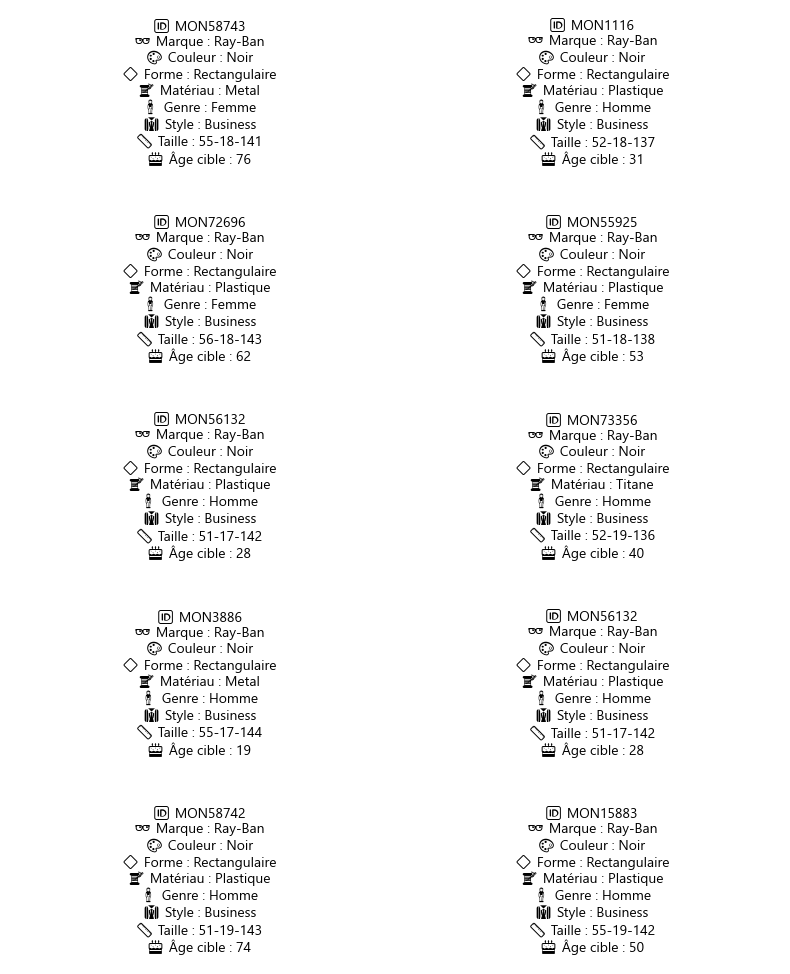

In [19]:
afficher_recommandations(df, montures_proches)

<details>
<summary>Clique ici pour voir explication clustering</summary>

🙌 Tu veux comprendre **comment utiliser un algorithme de clustering (comme KMeans ou DBSCAN)** pour recommander des montures à partir d’un **formulaire rempli par l’utilisateur**, **sans historique d’achat**.

C’est une approche **non supervisée** de type **content-based filtering**, mais au lieu d’utiliser k-NN ou la distance brute, on **structure l’espace en groupes (clusters)**, puis on **recommande des éléments du même groupe** que le profil utilisateur.

---

🧠 **Principe général d’un système de recommandation avec clustering**

1. 🔧 **Préparer les données** des montures (nettoyage + encodage)
2. 🧠 **Appliquer un clustering** (KMeans ou DBSCAN)
3. 🧑‍💻 L’utilisateur remplit un **formulaire**
4. 🧩 Le profil utilisateur est **encodé** avec les mêmes encodeurs
5. 🔍 On **identifie le cluster auquel il appartient**
6. 🎯 On **recommande des montures** de ce cluster

---

🧰 **Méthodes de clustering**

| Algo      | Idéal pour...                      | Comment ça marche ?                    |
|-----------|------------------------------------|----------------------------------------|
| **KMeans** | Données bien réparties, denses     | Regroupe par centre (proche du barycentre) |
| **DBSCAN**| Données bruitées, denses + creux    | Regroupe par **densité**, détecte le bruit |

---

🎯 **Exemple concret avec **KMeans****

🔁 **1. Pré-traitement global (1 seule fois)**
- Encoder toutes les montures (`df_clean`) → `X_encoded`
- Appliquer `KMeans(n_clusters=k)` → créer un champ `Cluster` dans `df_clean`

```python
kmeans.fit(X_encoded)
df_clean['Cluster'] = kmeans.labels_
```

---

🧑‍💼 **2. L'utilisateur remplit le formulaire**

Ex :

```python
profil = {
    'Genre': ['Femme'],
    'Marque': ['Ray-Ban'],
    'Type': ['Cerclée'],
    'Forme': ['Papillon'],
    'Materiau': ['Plastique'],
    'Couleur': ['Rouge'],
    'Style': ['Vintage'],
    'Age': [29],
    'Taille_Lens': [52],
    'Taille_Bridge': [16],
    'Taille_Temple': [140]
}
```

---

🧠 **3. Encoder ce profil avec les mêmes encodeurs :**

```python
profil_cat = ohe.transform(pd.DataFrame(profil)[cat_cols])
profil_num = scaler.transform(pd.DataFrame(profil)[num_cols])
profil_encoded = np.hstack([profil_cat, profil_num])
```

---

🧩 **4. Prédire le **cluster de ce profil** :**

```python
cluster_utilisateur = kmeans.predict(profil_encoded)[0]
```

---

🎯 **5. Recommander les montures de ce cluster :**

```python
df_recommandations = df_clean[df_clean['Cluster'] == cluster_utilisateur]
montures_recommandees = df_recommandations.sample(n=10)
```

---

✅ **Pourquoi c’est efficace ?**

| Avantage                             | Détail                                                |
|--------------------------------------|--------------------------------------------------------|
| Pas besoin d’historique d’achat      | Fonctionne juste avec les caractéristiques            |
| Plus rapide que k-NN                 | Pas besoin de recalculer toutes les distances         |
| Les clusters peuvent être personnalisés | Par genre, forme, style, etc.                          |

---

🔄 **Variante avec **DBSCAN****

- Même logique, sauf qu’on ne prédit pas de cluster pour un nouveau point par défaut
- Il faut utiliser `NearestNeighbors` ou `LOF` pour le faire manuellement
- **DBSCAN** est excellent si tu veux repérer les profils "hors norme" (bruit, outliers)

---

🔚 **Résumé : Pipeline avec KMeans**

```text
1. Encode df_clean → X_encoded
2. Clustering avec KMeans → créer df_clean['Cluster']
3. Formulaire utilisateur → encoder avec ohe + scaler
4. Prédire cluster du profil → kmeans.predict()
5. Recommander montures du même cluster
```

</details>

## **DBSCAN**

In [ ]:
# GridSearch DBSCAN
eps_values = [0.5, 1.0, 1.5, 2.0, 2.5]
min_samples_values = [5, 10, 15, 20]

results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=min_samples)
        labels = db.fit_predict(X_encoded)

        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)

        if n_clusters >= 2:
            score = silhouette_score(X_encoded, labels)
        else:
            score = np.nan

        results.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'silhouette_score': score
        })

# Résultats sous forme de DataFrame
df_results = pd.DataFrame(results)
df_results

eps  min_samples  n_clusters  n_noise  silhouette_score
0   0.5            5          23    99531         -0.307623
1   0.5           10           0    99654               NaN
2   0.5           15           0    99654               NaN
3   0.5           20           0    99654               NaN
4   1.0            5        1324    83161         -0.387064
5   1.0           10         112    96771         -0.350924
6   1.0           15          24    98932         -0.286782
7   1.0           20           3    99569         -0.162232
8   1.5            5         546    29607         -0.374284
9   1.5           10         156    55560         -0.338813
10  1.5           15          28    70811         -0.260579
11  1.5           20          15    80137         -0.234929
12  2.0            5           2      494          0.024592
13  2.0           10           1     1026               NaN
14  2.0           15           1     1777               NaN
15  2.0           20           1     2714               NaN
16  2.5            5           1        0               NaN
17  2.5           10           1        0               NaN
18  2.5           15           1        0               NaN
19  2.5           20           1        0               NaN

## **K-means**

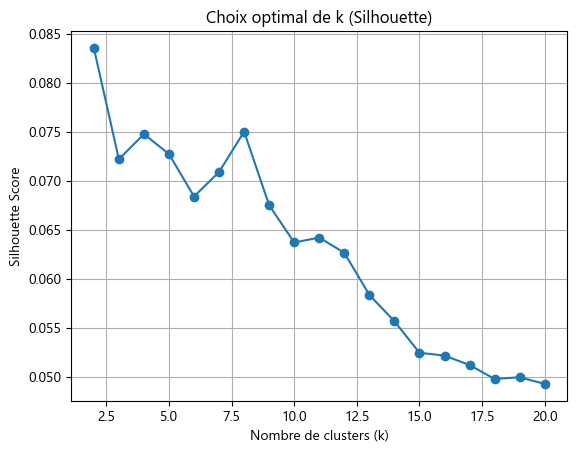

In [12]:
scores = []
ks = range(2, 21)

for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_encoded)
    s = silhouette_score(X_encoded, kmeans.labels_)
    scores.append(s)

# Affichage
plt.plot(ks, scores, marker='o')
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Choix optimal de k (Silhouette)")
plt.grid(True)
plt.show()
